In [3]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from keras.models import model_from_yaml

import os
print(os.listdir("train"))

#IMAGE_WIDTH=128
#IMAGE_HEIGHT=128
#IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
#IMAGE_CHANNELS=3

['.DS_Store', 'train2', 'train', 'train1']


In [4]:
filenames = os.listdir("train/train2")
categories = []
for filename in filenames:
    category = filename.split('.')[0] #yes.howard.jpg 有學習障礙的圖片名稱
    if category == 'yes':
        categories.append('1')
    else:
        categories.append('0')

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

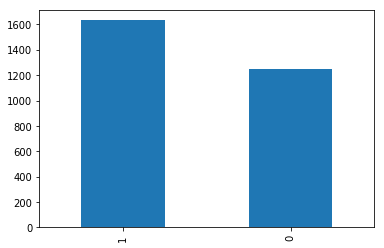

In [65]:
df['category'].value_counts().plot.bar()

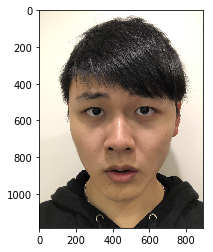

In [50]:
sample = random.choice(filenames)
image = load_img("train/train2/"+sample)
plt.imshow(image)

In [6]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128,128,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten()) #平坦層
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])#loss function #低度下降函數 #模型評估

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_17 (Batc (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_18 (Batc (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 30, 30, 64)        0         
__________

In [52]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [53]:
earlystop = EarlyStopping(patience=10) #提早終止 patience=10 相比上一個loss沒有下降則經過10次後停止訓練

In [54]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', #監測的數據
                                            patience=2, #沒有進步的訓練次數
                                            #verbose=1, #更新訊息
                                            factor=0.5, #learning rate變0.5倍
                                            min_lr=0.00001) #minimum of learning rate

In [55]:
callbacks = [earlystop, learning_rate_reduction] #回調函數

In [73]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42) #驗證集0.2 
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

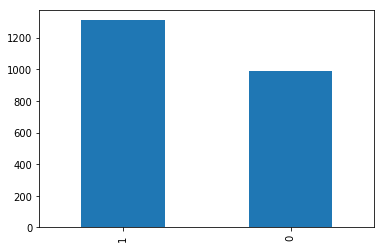

In [57]:
train_df['category'].value_counts().plot.bar()

In [66]:
df['category'].value_counts()

1    1632
0    1246
Name: category, dtype: int64

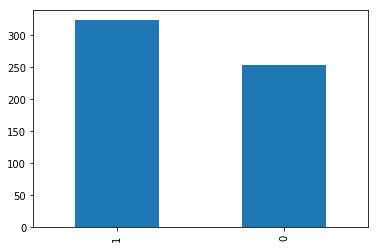

In [67]:
validate_df['category'].value_counts().plot.bar()

In [68]:
total_train = train_df.shape[0] #train數量
total_validate = validate_df.shape[0] #驗證數量
batch_size=15

In [69]:
#
train_datagen = ImageDataGenerator(#圖片生成器
    rotation_range=15, #圖片轉動角度
    rescale=1./255,  #圖片縮放
    shear_range=0.1, #剪裁強度
    zoom_range=0.2, #隨機縮放
    horizontal_flip=True, #隨機水平翻轉
    width_shift_range=0.1, #水瓶偏移幅度
    height_shift_range=0.1 #垂直偏移幅度
)

In [70]:
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "train/train2/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size
)

Found 2301 images belonging to 2 classes.


In [71]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "train/train2/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size
)

Found 575 images belonging to 2 classes.


In [74]:
epochs=10
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/10
153/153 [==============================] - 203s 1s/step - loss: 0.2523 - acc: 0.9346 - val_loss: 6.3726 - val_acc: 0.3368
Epoch 2/10
153/153 [==============================] - 205s 1s/step - loss: 0.2235 - acc: 0.9390 - val_loss: 5.4245 - val_acc: 0.3321
Epoch 3/10
153/153 [==============================] - 206s 1s/step - loss: 0.2435 - acc: 0.9342 - val_loss: 6.6294 - val_acc: 0.0446
Epoch 4/10
153/153 [==============================] - 208s 1s/step - loss: 0.2071 - acc: 0.9455 - val_loss: 5.4233 - val_acc: 0.4321
Epoch 5/10
153/153 [==============================] - 204s 1s/step - loss: 0.2007 - acc: 0.9449 - val_loss: 4.9015 - val_acc: 0.0518
Epoch 6/10
153/153 [==============================] - 208s 1s/step - loss: 0.1925 - acc: 0.9468 - val_loss: 4.5689 - val_acc: 0.0446
Epoch 7/10
153/153 [==============================] - 202s 1s/step - loss: 0.2061 - acc: 0.9427 - val_loss: 4.4273 - val_acc: 0.0464
Epoch 8/10
153/153 [==============================] - 254s 2s/step - 

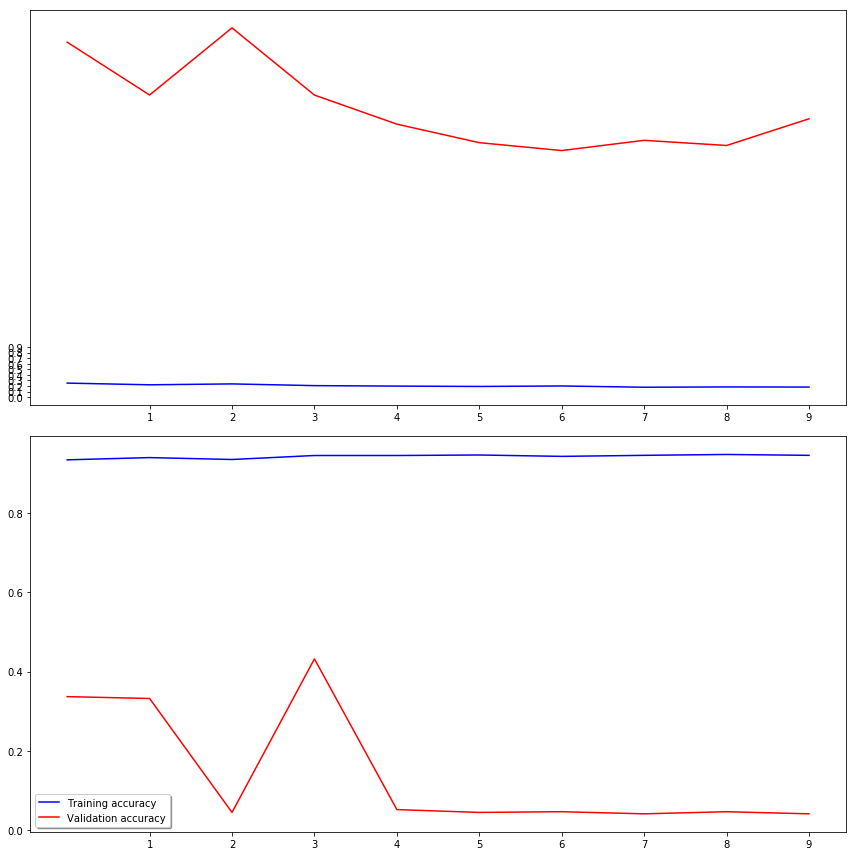

In [75]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [ ]:
model.save("model.h5")

In [76]:
test_filenames = os.listdir("test/test2")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [77]:
batch_size=15
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "test/test1", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 50 images.


In [78]:
from keras.models import load_model
model1 = load_model('model1.h5')

In [79]:
predict = model1.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [80]:
threshold = 0.5
test_df['probability'] = predict
test_df['category'] = np.where(test_df['probability'] > threshold, 1,0)

ValueError: Length of values does not match length of index

In [ ]:
test_df['category'].value_counts().plot.bar()

In [ ]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    probability = row['probability']
    img = load_img("test/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' '(' + "{}".format(round(probability, 2)) + ')')
plt.tight_layout()
plt.show()

In [ ]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)

In [ ]:
filenames = os.listdir("test/test1")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'yes':
        categories.append('1')
    else:
        categories.append('0')

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [ ]:
test = os.listdir("test/test1")
filename = test[0]
name = filename.split('_')[0]
article = filename.split('_')[1]

In [ ]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "train/train1/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary'
)

In [ ]:
example_df